In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

from models import TorchLogisticRegressor

from tqdm import tqdm
import numpy as np

### Load MNIST

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype('int')

train_samples=5000
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

### Run HyperParam Exploration

In [29]:
results = []

for w in tqdm([0, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0]):
    for reg_type in ['l1', 'l2']:
        if w == 0:
            c = np.inf
            penalty = None
            reg_type = 'none'
        else:
            c = 1/w
            penalty = reg_type
        if reg_type == 'l1':
            l1_w = w
            l2_w = 0
            solver = 'liblinear'
        elif reg_type == 'l2':
            l1_w = 0
            l2_w = w
            solver = 'lbfgs'
        elif reg_type == 'none':
            l1_w = 0
            l2_w = 0
            solver = 'lbfgs'
        model_sk = LogisticRegression(penalty = penalty, C=c, max_iter=1000, tol=0.0001, solver=solver)
        model_torch = TorchLogisticRegressor(lr=1, l1_w=l1_w, l2_w=l2_w, max_iterations=1000, tolerance=0.0001)

        s = time.time()
        model_sk.fit(X_train, y_train)
        pred_sk = model_sk.predict(X_test)
        time_sk = time.time() - s

        s = time.time()
        model_torch.fit(X_train, y_train)
        pred_torch = model_torch.predict(X_test)
        time_torch = time.time() - s
        
        acc_sk = (pred_sk == y_test).mean()
        acc_torch = (np.argmax(pred_torch, axis=1) == y_test).mean()

        results.append({'w': w, 'reg_type': reg_type, 'sk': acc_sk, 'torch': acc_torch, 'time_sk': time_sk, 'time_torch': time_torch})
        
        

  0%|                                                                                                                                                         | 0/8 [00:00<?, ?it/s]/home/lpepino/miniconda3/envs/encodecmae-v2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/lpepino/miniconda3/envs/encodecmae-v2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:00<00:00,  7.59s/it]


In [30]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(results)
df['C'] = 1/df['w']

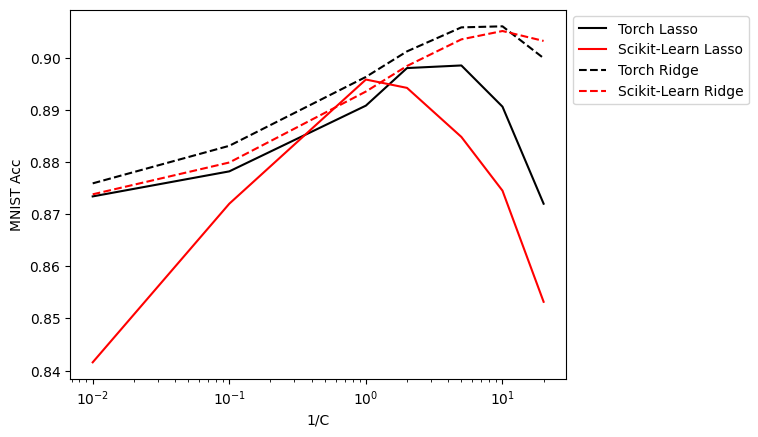

In [31]:
df_l1 = df.loc[df['reg_type'] == 'l1']
df_l2 = df.loc[df['reg_type'] == 'l2']

plt.plot(df_l1['w'], df_l1['torch'], '-k', label='Torch Lasso')
plt.plot(df_l1['w'], df_l1['sk'], '-r', label='Scikit-Learn Lasso')

plt.plot(df_l2['w'], df_l2['torch'], '--k', label='Torch Ridge')
plt.plot(df_l2['w'], df_l2['sk'], '--r', label='Scikit-Learn Ridge')

plt.legend(bbox_to_anchor=[1,1,0,0])
plt.xlabel('1/C')
plt.ylabel('MNIST Acc')
plt.xscale('log')

Text(0.5, 1.0, 'Fit + Predict Times')

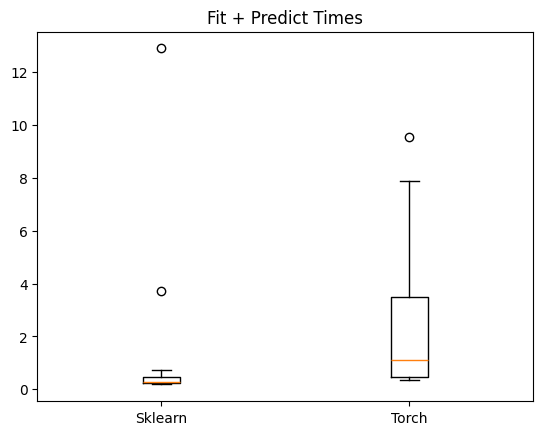

In [39]:
_ = plt.boxplot([df['time_sk'], df['time_torch']], labels=['Sklearn', 'Torch'])
plt.title('Fit + Predict Times')